<a href="https://colab.research.google.com/github/Mansingh7697/21112023/blob/main/Traffic_Flow_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import Libraries:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# @title Function Initilization:
def get_routes(num_junctions):
    routes = []
    for i in range(num_junctions):
        junction_name = chr(65 + i)  # Convert to letters A, B, C, etc.
        inflow = input(f"Enter the inflow for junction {junction_name} (comma-separated, e.g. x1,5,x2): ")
        outflow = input(f"Enter the outflow for junction {junction_name} (comma-separated, e.g. x3,10,x4): ")
        inflow = inflow.split(',') if inflow else []
        outflow = outflow.split(',') if outflow else []
        routes.append((junction_name, inflow, outflow))
    return routes

def draw_graph(routes):
    G = nx.DiGraph()
    node_labels = {}
    edge_labels = {}

    # Add nodes and edges to the graph
    for junction_name, inflow, outflow in routes:
        inflow_label = ' + '.join(inflow)
        outflow_label = ' + '.join(outflow)
        G.add_node(junction_name, inflow=inflow_label, outflow=outflow_label)
        node_labels[junction_name] = junction_name  # Only display junction names inside nodes

        for var in inflow:
            if var.startswith('x') or var.isdigit():
                to_node = junction_name
                edge_value = var
                matched = False
                for other_junction_name, other_inflow, other_outflow in routes:
                    if var in other_outflow:
                        from_node = other_junction_name
                        G.add_edge(from_node, to_node, value=edge_value)
                        matched = True
                        break
                if not matched:
                    open_node = f"In_{var}"
                    G.add_node(open_node)
                    G.add_edge(open_node, to_node, value=edge_value)

        for var in outflow:
            if var.startswith('x') or var.isdigit():
                from_node = junction_name
                edge_value = var
                matched = False
                for other_junction_name, other_inflow, other_outflow in routes:
                    if var in other_inflow:
                        to_node = other_junction_name
                        G.add_edge(from_node, to_node, value=edge_value)
                        matched = True
                        break
                if not matched:
                    open_node = f"Out_{var}"
                    G.add_node(open_node)
                    G.add_edge(from_node, open_node, value=edge_value)

    # pos = nx.circular_layout(G)
    pos = nx.planar_layout(G)
    # pos = nx.spring_layout(G, seed=36)
    plt.figure(figsize=(12, 8))

    # Draw nodes with junction names inside
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', edgecolors='black')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_family="sans-serif", verticalalignment='center')

    # Draw edges and edge labels
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    edge_labels = {(u, v): d['value'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    # Draw inflow and outflow labels outside the nodes
    for node, (x, y) in pos.items():
        inflow_label = G.nodes[node].get('inflow', '')
        outflow_label = G.nodes[node].get('outflow', '')

        # Position inflow label slightly above the node
        if inflow_label:
            plt.text(x, y+0.06, f"In: {inflow_label}", fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.7))

        # Position outflow label slightly below the node
        if outflow_label:
            plt.text(x, y-0.06, f"Out: {outflow_label}", fontsize=10, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Traffic Flow Problem Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def generate_equations(routes, num_variables):
    equations = []
    for junction_name, inflow, outflow in routes:
        lhs = ""
        rhs = 0
        for var in inflow:
            if var.startswith('x'):
                lhs += f"+{var}"
            else:
                rhs -= float(var)
        for var in outflow:
            if var.startswith('x'):
                lhs += f"-{var}"
            else:
                rhs += float(var)
        equations.append((lhs, rhs))
    return equations

def parse_equations(equations, num_variables):
    coeff_matrix = np.zeros((len(equations), num_variables))
    constants = np.zeros(len(equations))

    for i, (lhs, rhs) in enumerate(equations):
        lhs = lhs.replace(" ", "").replace("-", "+-")
        terms = lhs.split('+')
        for term in terms:
            if term and 'x' in term:
                coeff = term[0] if term[0] in "+-" else "+"
                var_idx = int(term.split('x')[1]) - 1
                coeff_matrix[i, var_idx] += float(coeff + "1")
        constants[i] = rhs

    return coeff_matrix, constants

def reduced_row_echelon_form(A):
    A = np.array(A, dtype=np.float64)
    rows, cols = A.shape
    row = 0
    for col in range(cols):
        if row >= rows:
            break
        if A[row, col] == 0:
            for i in range(row + 1, rows):
                if A[i, col] != 0:
                    A[[row, i]] = A[[i, row]]
                    break
        if A[row, col] != 0:
            A[row] = A[row] / A[row, col]
            for i in range(rows):
                if i != row:
                    A[i] = A[i] - A[i, col] * A[row]
            row += 1
    return A

def solve_system(coeff_matrix, constants):
    rank = np.linalg.matrix_rank(coeff_matrix)
    augmented_matrix = np.c_[coeff_matrix, constants]
    augmented_rank = np.linalg.matrix_rank(augmented_matrix)
    rref = reduced_row_echelon_form(augmented_matrix.copy())
    print("\nRow Echelon Form of the augmented matrix:")
    print(rref)
    print(f"\nRank of coefficient matrix is {rank}.")
    print(f"Rank of augmented matrix is {augmented_rank}")

    if rank < augmented_rank:
        print("\nNo solution exists.")
        return
    elif rank < len(coeff_matrix[0]):
        print("\nInfinite solutions exist. Please provide a value for one of the unknowns.")
        variable = int(input(f"Choose a variable to assign a value (1-{coeff_matrix.shape[1]}): ")) - 1
        value = float(input(f"Enter the value for x{variable+1}: "))
        constants -= value * coeff_matrix[:, variable]
        reduced_matrix = np.delete(coeff_matrix, variable, axis=1)
        solution = np.linalg.lstsq(reduced_matrix, constants, rcond=None)[0]
        solution = np.insert(solution, variable, value)
    else:
        solution = np.linalg.solve(coeff_matrix, constants)

    print("\nSolution is:")
    for i, sol in enumerate(solution):
        print(f"x{i+1} = {sol:.2f}")


In [ ]:
# @title Enter Junctions:
num_junctions = int(input("Enter the number of junctions: "))

Enter the number of junctions: 3


In [ ]:
# @title Enter number of unknown variables(Routes):
num_variables = int(input("Enter the number of routes (unknown variables): "))

Enter the number of routes (unknown variables): 4


Define the routes for each junction:
Enter the inflow for junction A (comma-separated, e.g. x1,5,x2): 50,x3
Enter the outflow for junction A (comma-separated, e.g. x3,10,x4): x1
Enter the inflow for junction B (comma-separated, e.g. x1,5,x2): x1
Enter the outflow for junction B (comma-separated, e.g. x3,10,x4): x2,x4
Enter the inflow for junction C (comma-separated, e.g. x1,5,x2): x2
Enter the outflow for junction C (comma-separated, e.g. x3,10,x4): x3,30


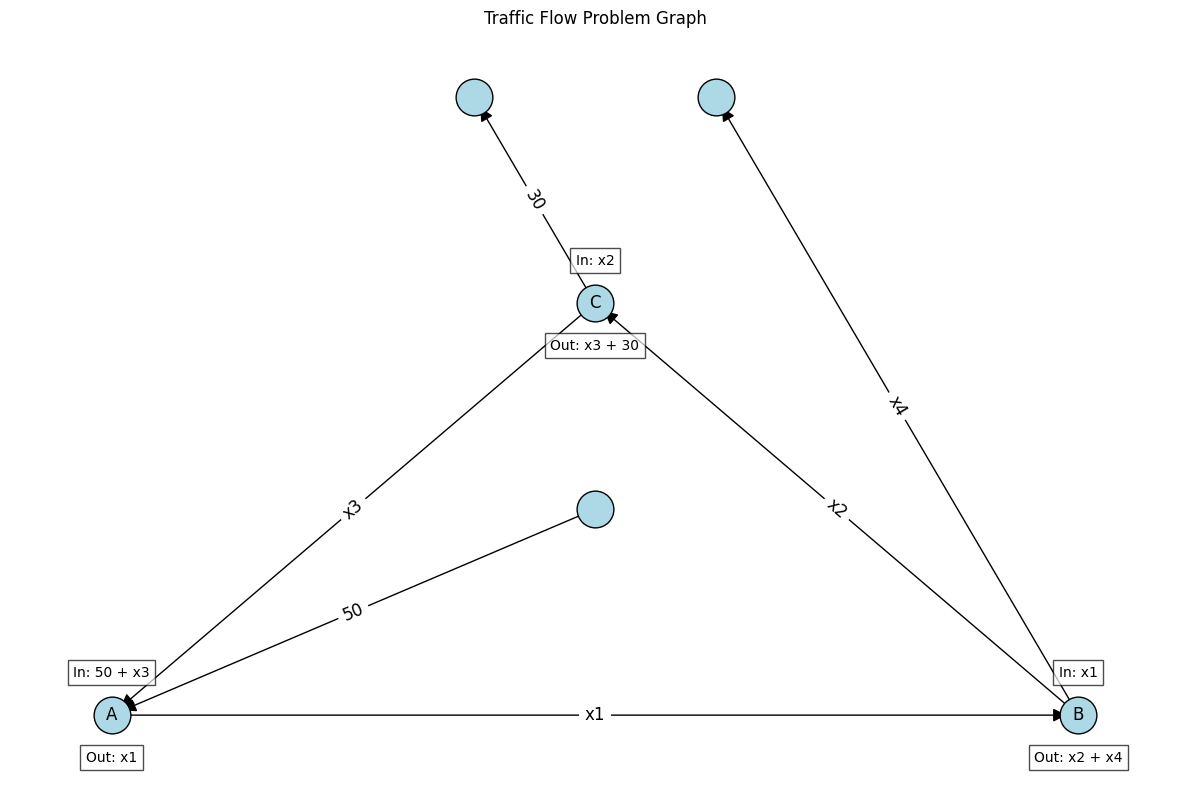

In [ ]:
# @title Enter route details:
print("Define the routes for each junction:")
routes = get_routes(num_junctions)
draw_graph(routes)

In [ ]:
# @title Get Traffic flow Equations
equations = generate_equations(routes, num_variables)

print("\nTraffic flow equations:")
for lhs, rhs in equations:
  print(f"{lhs} = {rhs}")


Traffic flow equations:
+x3-x1 = -50.0
+x1-x2-x4 = 0
+x2-x3 = 30.0


In [ ]:
# @title Get Coefficient and Constant Matrices:
coeff_matrix, constants = parse_equations(equations, num_variables)

print("\nTraffic flow equations coefficient matrix:")
print(coeff_matrix)

print("\nTraffic flow equations constant vector:")
print(constants)


Traffic flow equations coefficient matrix:
[[-1.  0.  1.  0.]
 [ 1. -1.  0. -1.]
 [ 0.  1. -1.  0.]]

Traffic flow equations constant vector:
[-50.   0.  30.]


In [ ]:
# @title Solution:
print(f"Number of unknowns are {num_variables}")
solve_system(coeff_matrix, constants)

Number of unknowns are 4

Row Echelon Form of the augmented matrix:
[[ 1.  0. -1.  0. 50.]
 [ 0.  1. -1.  0. 30.]
 [-0. -0. -0.  1. 20.]]

Rank of coefficient matrix is 3.
Rank of augmented matrix is 3

Infinite solutions exist. Please provide a value for one of the unknowns.
Choose a variable to assign a value (1-4): 1
Enter the value for x1: 60

Solution is:
x1 = 60.00
x2 = 40.00
x3 = 10.00
x4 = 20.00
